In [1]:
import pylab
import h5py
import math
import array
from numpy import *
import numpy as np
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.waveform import get_td_waveform, get_fd_waveform

from gw_eccentricity import load_waveform, load_data, get_available_methods, measure_eccentricity
from gw_eccentricity.load_data import get_available_waveform_origins, get_load_waveform_defaults, get_load_waveform_docs

from gw_eccentricity.plot_settings import use_fancy_plotsettings, labelsDict
from pycbc.waveform.waveform_modes import get_td_waveform_modes
from pycbc import types, fft, waveform
import lal
from scipy import interpolate
from scipy.interpolate import interp1d
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI, PI
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from tqdm import tqdm#

#from matplotlib import rcParams
#rcParams.update({'figure.autolayout': True})
import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 200
#plt.rcParams["font.family"] = "monospace"
 
from matplotlib import gridspec
from matplotlib import ticker

import matplotlib.pyplot as plt
#plt.style.reload_library()
#plt.style.use(['science','notebook'])



#pylab.rc('xtick', labelsize=18) 
#pylab.rc('ytick', labelsize=18) 
#pylab.rc('axes', labelsize=16)
#pylab.rc('legend', fontsize=15)


0.21049312028261025


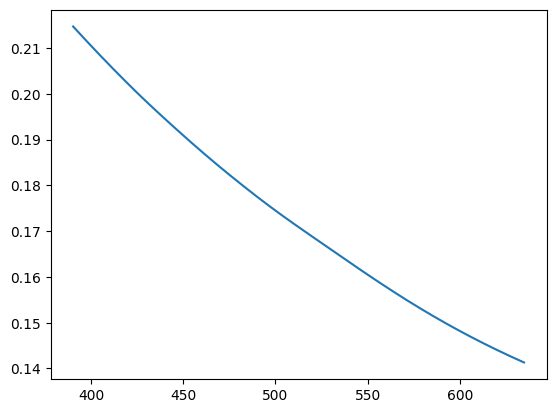

In [2]:
q=1/0.82
#ecc= [0.0091,0.013,0.029,0.038,0.070,0.13]
ecc = [0.13]
#m_omega=[0.020322,0.021330,0.018717,0.19363,0.018392,0.017351]
m_omega = [0.017351]
for i in range(len(ecc)):
    kwargs = {
            "approximant": "EccentricTD",
            "q": q,
            "ecc": ecc[i],
            "chi1": [0.0,0.0,0.0],
            "chi2": [0.0,0.0,0.0],
            "mean_ano": 0.0,
            "Momega0": m_omega[i],
            "physicalUnits":True,
            "M":30,
            "D":1,
            "include_zero_ecc":True
            }
    origin = "LAL"
    dataDict = load_waveform(origin, **kwargs)
    method = "ResidualAmplitude"
    Time = dataDict["t"]
    return_dict = measure_eccentricity(fref_in = 55, method=method, dataDict = dataDict)
    gwecc_object= return_dict["gwecc_object"]

    Time_data=gwecc_object.get_omega22_average()[0]
    Omega_avg = gwecc_object.get_omega22_average()[1] 
    return_dict = measure_eccentricity(tref_in = Time_data, method=method, dataDict = dataDict)
    ecc=return_dict["eccentricity"]
    plt.plot(Omega_avg/2*PI,ecc)
    Ecc_intrp = interp1d(Omega_avg/2*PI,ecc,kind='cubic',fill_value='extrapolate')
    print(Ecc_intrp(400))
    #plt.xlim(450,700)

# PN Hybrid comparison

In [3]:
# Eq. (4.17a, 4.17b), Pg. 18, Moore et al (2016)

def epsilon(xi, eta):
    return(( 1 + ( ( -2833/2016 + 197/72 * eta ) * ( xi )**( 2/3 ) + 
                  ( -377/144 * np.pi * xi + ( ( 77006005/24385536 + ( -1143767/145152 * eta + 
 	 43807/10368 * ( eta )**( 2 ) ) ) * ( xi )**( 4/3 ) + ( np.pi * ( 9901567/1451520 + 
 	 -202589/362880 * eta ) * ( xi )**( 5/3 ) + ( xi )**( 2 ) * ( -33320661414619/386266890240 + 
 	 ( 3317/252 * EulerGamma + ( 180721/41472 * ( np.pi )**( 2 ) + ( ( 161339510737/8778792960 + 
 	 3977/2304 * ( np.pi )**( 2 ) ) * eta + ( -359037739/20901888 * ( eta )**( 2 ) + 
      ( 10647791/2239488 * ( eta )**( 3 ) + ( -87419/3780 * np.log( 2 ) + 
 	 ( 26001/1120 * np.log( 3 ) + 3317/504 * np.log( 16 * ( xi )**( 2/3 ) ) ) ) ) ) ) ) ) ) ) ) ) ) ))

In [4]:
# "Hinder+ modified all 20 simulations SEOBNRv4 model, full frequency range --Feb 16
g=open('tshift_H+modified_20hyb_Feb16.txt',"r") 
lines=g.readlines() 
A=[] 
for x in lines: 
    A.append(float(x.split()[1])) 
g.close()

def tshift_Hinsp(q,e,l): 
    return A[0] + A[1]*q + A[2]*q**2 + A[3]*e + A[4]*e**2 + A[5]*e**3 + A[6]*e*q + A[7]*(e**2)*q + A[8]*e*(q**2) + A[9]*(e**2)*(q**2) + A[10]*(e**3)*q + A[11]*e*q*math.cos(l + A[12]) + A[13]*(e**2)*(q**2)*math.cos(e*l + A[14]) + A[15]*(e**3)*q*math.cos(l + A[16]) + A[17]*e*(q**2)*math.cos(l + A[18])

g=open('tamp_H+modified_20hyb_Feb16.txt',"r") 
lines=g.readlines() 
B=[] 
for x in lines: 
    B.append(float(x.split()[1])) 
g.close()

def tamp_Hinsp(eta,e,l): 
    return B[0] + B[1]*eta + B[2]*eta**2 + B[3]*e + B[4]*e**2 + B[5]*e**3 + B[6]*e*eta + B[7]*(e**2)*eta + B[8]*e*(eta**2) + B[9]*(e**2)*(eta**2) + B[10]*(e**3)*eta + B[11]*e*eta*math.cos(l + B[12]) + B[13]*(e**2)*(eta**2)*math.cos(l + B[14]) + B[15]*(e**3)*eta*math.cos(e*l + B[16])

g=open('tfreq_H+modified_20hyb_Feb16.txt',"r") 
lines=g.readlines() 
C=[] 
for x in lines: 
    C.append(float(x.split()[1])) 
g.close()

def tfreq_Hinsp(eta,e,l): 
    return C[0] + C[1]*eta + C[2]*eta**2 + C[3]*e + C[4]*e**2 + C[5]*e**3 + C[6]*e*eta + C[7]*(e**2)*eta + C[8]*e*(eta**2) + C[9]*(e**2)*(eta**2) + C[10]*(e**3)*eta + C[11]*e*eta*math.cos(l + C[12]) + C[13]*(e**2)*(eta**2)*math.cos(l + C[14]) + C[15]*(e**3)*eta*math.cos(e*l + C[16])+ C[17]*(e**3)*(eta**2)*math.cos(e*l + C[18])

In [5]:
def xi(x):
    return x**(3/2)

def xconv(f,M):
    return (PI*M*MTSUN_SI*f)**(2/3)  #22 mode conversion

def fconv(x,M):
    return x**(3/2)/(PI*M*MTSUN_SI)  #22 mode conversion


In [6]:
def INSP_Eber22(M0,q,e0,l0,flow,inc,d0,delta_t):
    eta=neu=nu=q/(1+q)**2
    G=C=M=d=1
    M2=M/(1+q)
    M1=M2*q
    Delta=math.sqrt(1-(4*neu))
    incl = inc
    x0=xlow=((M0*MTSUN_SI*math.pi*flow)**(2/3))
    M_SI = M0 * MSUN_SI
    D_SI=(10**(6)) * PC_SI * d
    
    %run GW_functions.ipynb

    kwargs = {
        "approximant": "EccentricTD",
        "q": q,
        "ecc": e0,
        "chi1": [0.0,0.0,0.0],
        "chi2": [0.0,0.0,0.0],
        "mean_ano": l0,
        "Momega0": xlow**(3/2),  #xlow = 0.045 corresponds to 616 Hz. For PN-NR comp. use 0.045, For match calculation use 0.053
        "physicalUnits":True,
        "M": M0,
        "D":d0,
        "include_zero_ecc":True,
        }

    mode2polfac=(5/(64*np.pi))**(1/2)   
    method = "ResidualAmplitude"
    origin = "LAL"
    dataDict2 = load_waveform(origin, **kwargs)
    hp22 = np.real(dataDict2["hlm"][(2,2)])
    hc22 = np.imag(dataDict2["hlm"][(2,2)])
    
    Time_data1 = dataDict2["t"]
    phs = np.unwrap(np.angle(hp22-1j*hc22)*2)/2
    
    return_dict1 = measure_eccentricity(tref_in=Time_data1,method=method,dataDict=dataDict2)
    gwecc_object = return_dict1["gwecc_object"]
    
    Time_data = gwecc_object.get_omega22_average()[0] 
    Omega_avg = gwecc_object.get_omega22_average()[1]
    
    Omega_avg_intrp = interp1d(Time_data, Omega_avg, kind='cubic', fill_value = 'extrapolate')
    Omega_avg = Omega_avg_intrp(Time_data1)
    del_t=np.abs(np.mean((np.diff(Time_data1))))
    

    
    omega3 = (M0*MTSUN_SI/del_t)*np.gradient(phs)

       
    Fvec = Omega_avg/(2*PI) #Average frequency array

    Fvec=Fvec*(M0*MTSUN_SI)
    
    return_dict1 = measure_eccentricity(tref_in=Time_data,method=method,dataDict=dataDict2)
    Eccentricity_new = return_dict1["eccentricity"]
    Eccentricity_new_intrp = interp1d(Time_data, Eccentricity_new, kind='cubic', fill_value = 'extrapolate')
    Eccentricity_new = Eccentricity_new_intrp(Time_data1)
    Mean_anomaly = return_dict1["mean_anomaly"]
    Mean_anomaly_intrp = interp1d(Time_data, Mean_anomaly, kind='cubic', fill_value = 'extrapolate')
    Mean_anomaly = Mean_anomaly_intrp(Time_data1)
    

    xiVec=(np.pi*M*Fvec)
    xVec=xiVec**(2/3)
    vVec=xiVec**(1/3)
    xVec = xVec

    phs=phs-phs[0]
    
    lp=2
    mp=2
    
    j=0
    h22=[]
    h2_2=[]
    for i in tqdm(xVec):    #tqdm(xVec) for status bar
        v=math.sqrt(i)
        v0=math.sqrt(x0)
        xie=v**3
        xi0=v0**3
        l=Mean_anomaly[j]
        e=Eccentricity_new[j]
        psi= phs[j] #phase_EccTD[j]
        j=j+1
        xi=l   #use xi for amplitude (xie is being used for v**3)
        x=i
        h=amplitude_22(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
 
        hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
        hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        
        h22.append(hlm) 
        h2_2.append(hl_m)
        
    conv_t = M0*MTSUN_SI
    conv_h = G_SI*M0*MSUN_SI/(10**6 * PC_SI * d0)/C_SI/C_SI
    
    #sph22, sph2_2 = sph_harmonics(incl,lp)
    
    h = np.multiply(h22,1) #+np.multiply(h2_2,sph2_2) chnge
    hp=(np.real(h)) 
    hc=(np.imag(h)) 

    mode2polfac=(5/(64*np.pi))**(1/2) 
    
    hp = np.array(hp) * conv_h
    hc = np.array(hc) * conv_h
    time = Time_data1
    hp_intrp_new = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
    hc_intrp_new = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
    t_intrp_new2 = np.arange(Time_data1[0], Time_data1[-1], del_t)
    hp_intrp_new2 = hp_intrp_new(t_intrp_new2)
    hc_intrp_new2 = hc_intrp_new(t_intrp_new2)
    
    #print(time/(M0*MTSUN_SI))
    #print(Time_data1/(M0*MTSUN_SI))
    #plt.yscale('log')
    #plt.ylim(ymax=1e-1)
    #plt.ylim(ymin=2e-4)
    #plt.xlim(xmin=-2500)
    #plt.xlim(xmax=450)
    #plt.plot(t_intrp_new3/(M0*MTSUN_SI),abs(hp_intrp_new3+1j*hc_intrp_new3)/(mode3polfac * G_SI*M_SI/D_SI/C_SI/C_SI),'r-',label='new')
    
    return np.array(hp_intrp_new2), np.array(hc_intrp_new2), np.array(t_intrp_new2)

In [7]:
def INSP_Eber21(M0,q,e0,l0,flow,inc,d0,delta_t):
    eta=neu=nu=q/(1+q)**2
    G=C=M=d=1
    M2=M/(1+q)
    M1=M2*q
    Delta=math.sqrt(1-(4*neu))
    incl = inc
    x0=xlow=0.045
    M_SI = M0 * MSUN_SI
    D_SI=(10**(6)) * PC_SI * d
    
    %run GW_functions.ipynb

    kwargs = {
        "approximant": "EccentricTD",
        "q": q,
        "ecc": e0,
        "chi1": [0.0,0.0,0.0],
        "chi2": [0.0,0.0,0.0],
        "mean_ano": l0,
        "Momega0": 0.045**(3/2),
        "physicalUnits":True,
        "M": M0,
        "D":d0,
        "include_zero_ecc":True,
        }

    mode2polfac=(5/(64*np.pi))**(1/2)   
    method = "ResidualAmplitude"
    origin = "LAL"
    dataDict2 = load_waveform(origin, **kwargs)
    hp22 = np.real(dataDict2["hlm"][(2,2)])
    hc22 = np.imag(dataDict2["hlm"][(2,2)])
    
    Time_data1 = dataDict2["t"]
    phs = np.unwrap(np.angle(hp22-1j*hc22)*2)/2
    
    return_dict1 = measure_eccentricity(tref_in=Time_data1,method=method,dataDict=dataDict2)
    gwecc_object = return_dict1["gwecc_object"]
    
    Time_data = gwecc_object.get_omega22_average()[0] 
    Omega_avg = gwecc_object.get_omega22_average()[1]
    
    Omega_avg_intrp = interp1d(Time_data, Omega_avg, kind='cubic', fill_value = 'extrapolate')
    Omega_avg = Omega_avg_intrp(Time_data1)
    del_t=np.abs(np.mean((np.diff(Time_data1))))
    

    
    omega3 = (M0*MTSUN_SI/del_t)*np.gradient(phs)

       
    Fvec = Omega_avg/(2*PI) #Average frequency array

    Fvec=Fvec*(M0*MTSUN_SI)
    
    return_dict1 = measure_eccentricity(tref_in=Time_data,method=method,dataDict=dataDict2)
    Eccentricity_new = return_dict1["eccentricity"]
    Eccentricity_new_intrp = interp1d(Time_data, Eccentricity_new, kind='cubic', fill_value = 'extrapolate')
    Eccentricity_new = Eccentricity_new_intrp(Time_data1)
    Mean_anomaly = return_dict1["mean_anomaly"]
    Mean_anomaly_intrp = interp1d(Time_data, Mean_anomaly, kind='cubic', fill_value = 'extrapolate')
    Mean_anomaly = Mean_anomaly_intrp(Time_data1)
    

    xiVec=(np.pi*M*Fvec)
    xVec=xiVec**(2/3)
    vVec=xiVec**(1/3)
    xVec = xVec

    phs=phs-phs[0]
    lp=2
    mp=1
    
    j=0
    h22=[]
    h2_2=[]
    for i in tqdm(xVec):    #tqdm(xVec) for status bar
        v=math.sqrt(i)
        v0=math.sqrt(x0)
        xie=v**3
        xi0=v0**3
        l=Mean_anomaly[j]
        e=Eccentricity_new[j]
        psi= phs[j] #phase_EccTD[j]
        j=j+1
        xi=l   #use xi for amplitude (xie is being used for v**3)
        x=i
        h=amplitude_21(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
 
        hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
        hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        
        h22.append(hlm) 
        h2_2.append(hl_m)
        
    conv_t = M0*MTSUN_SI
    conv_h = G_SI*M0*MSUN_SI/(10**6 * PC_SI * d0)/C_SI/C_SI
    
    #sph22, sph2_2 = sph_harmonics(incl,lp)
    
    h = np.multiply(h22,1) #+np.multiply(h2_2,sph2_2) chnge
    hp=(np.real(h)) 
    hc=(np.imag(h)) 

    mode2polfac=(5/(64*np.pi))**(1/2) 
    
    hp = np.array(hp) * conv_h
    hc = np.array(hc) * conv_h
    time = Time_data1
    hp_intrp_new = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
    hc_intrp_new = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
    t_intrp_new2 = np.arange(Time_data1[0], Time_data1[-1], del_t)
    hp_intrp_new2 = hp_intrp_new(t_intrp_new2)
    hc_intrp_new2 = hc_intrp_new(t_intrp_new2)
    
    #print(time/(M0*MTSUN_SI))
    #print(Time_data1/(M0*MTSUN_SI))
    #plt.yscale('log')
    #plt.ylim(ymax=1e-1)
    #plt.ylim(ymin=2e-4)
    #plt.xlim(xmin=-2500)
    #plt.xlim(xmax=450)
    #plt.plot(t_intrp_new3/(M0*MTSUN_SI),abs(hp_intrp_new3+1j*hc_intrp_new3)/(mode3polfac * G_SI*M_SI/D_SI/C_SI/C_SI),'r-',label='new')
    
    return np.array(hp_intrp_new2), np.array(hc_intrp_new2), np.array(t_intrp_new2)

In [8]:
def INSP_Eber33(M0,q,e0,l0,flow,inc,d0,delta_t):
    eta=neu=nu=q/(1+q)**2
    G=C=M=d=1
    M2=M/(1+q)
    M1=M2*q
    Delta=math.sqrt(1-(4*neu))
    incl = inc
    x0=xlow=0.045
    M_SI = M0 * MSUN_SI
    D_SI=(10**(6)) * PC_SI * d
    
    %run GW_functions.ipynb

    kwargs = {
        "approximant": "EccentricTD",
        "q": q,
        "ecc": e0,
        "chi1": [0.0,0.0,0.0],
        "chi2": [0.0,0.0,0.0],
        "mean_ano": l0,
        "Momega0": 0.045**(3/2),
        "physicalUnits":True,
        "M": M0,
        "D":d0,
        "include_zero_ecc":True,
        }

    mode3polfac=(21/(2*np.pi))**(1/2)    
    method = "ResidualAmplitude"
    origin = "LAL"
    dataDict2 = load_waveform(origin, **kwargs)
    hp33 = np.real(dataDict2["hlm"][(2,2)])
    hc33 = np.imag(dataDict2["hlm"][(2,2)])
    
    Time_data1 = dataDict2["t"]
    phs = np.unwrap(np.angle(hp33-1j*hc33)*2)/2
    
    return_dict1 = measure_eccentricity(tref_in=Time_data1,method=method,dataDict=dataDict2)
    gwecc_object = return_dict1["gwecc_object"]
    
    Time_data = gwecc_object.get_omega22_average()[0] 
    Omega_avg = gwecc_object.get_omega22_average()[1]
    
    Omega_avg_intrp = interp1d(Time_data, Omega_avg, kind='cubic', fill_value = 'extrapolate')
    Omega_avg = Omega_avg_intrp(Time_data1)
    del_t=np.abs(np.mean((np.diff(Time_data1))))
    

    
    omega3 = (M0*MTSUN_SI/del_t)*np.gradient(phs)

       
    Fvec = Omega_avg/(2*PI) #Average frequency array

    Fvec=Fvec*(M0*MTSUN_SI)
    
    return_dict1 = measure_eccentricity(tref_in=Time_data,method=method,dataDict=dataDict2)
    Eccentricity_new = return_dict1["eccentricity"]
    Eccentricity_new_intrp = interp1d(Time_data, Eccentricity_new, kind='cubic', fill_value = 'extrapolate')
    Eccentricity_new = Eccentricity_new_intrp(Time_data1)
    Mean_anomaly = return_dict1["mean_anomaly"]
    Mean_anomaly_intrp = interp1d(Time_data, Mean_anomaly, kind='cubic', fill_value = 'extrapolate')
    Mean_anomaly = Mean_anomaly_intrp(Time_data1)
    

    xiVec=(np.pi*M*Fvec)
    xVec=xiVec**(2/3)
    vVec=xiVec**(1/3)
    xVec = xVec

    phs=phs-phs[0]
    lp=3
    mp=3
    
    j=0
    h33=[]
    h3_3=[]
    for i in tqdm(xVec):    #tqdm(xVec) for status bar
        v=math.sqrt(i)
        v0=math.sqrt(x0)
        xie=v**3
        xi0=v0**3
        l=Mean_anomaly[j]
        e=Eccentricity_new[j]
        psi= phs[j] #phase_EccTD[j]
        j=j+1
        xi=l   #use xi for amplitude (xie is being used for v**3)
        x=i
        h=amplitude_33(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
 
        hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
        hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        
        h33.append(hlm) 
        h3_3.append(hl_m)
        
    conv_t = M0*MTSUN_SI
    conv_h = G_SI*M0*MSUN_SI/(10**6 * PC_SI * d0)/C_SI/C_SI
    
    #sph33, sph3_3 = sph_harmonics(incl,lp)
    
    h = np.multiply(h33,1) #+np.multiply(h2_2,sph2_2) chnge
    hp=(np.real(h)) 
    hc=(np.imag(h)) 

    mode3polfac=(21/(2*np.pi))**(1/2)
    
    hp = np.array(hp) * conv_h
    hc = np.array(hc) * conv_h
    time = Time_data1
    hp_intrp_new = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
    hc_intrp_new = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
    t_intrp_new3 = np.arange(Time_data1[0], Time_data1[-1], del_t)
    hp_intrp_new3 = hp_intrp_new(t_intrp_new3)
    hc_intrp_new3 = hc_intrp_new(t_intrp_new3)
    
    #print(time/(M0*MTSUN_SI))
    #print(Time_data1/(M0*MTSUN_SI))
    #plt.yscale('log')
    #plt.ylim(ymax=1e-1)
    #plt.ylim(ymin=2e-4)
    #plt.xlim(xmin=-2500)
    #plt.xlim(xmax=450)
    #plt.plot(t_intrp_new3/(M0*MTSUN_SI),abs(hp_intrp_new3+1j*hc_intrp_new3)/(mode3polfac * G_SI*M_SI/D_SI/C_SI/C_SI),'r-',label='new')

    return np.array(hp_intrp_new3), np.array(hc_intrp_new3), np.array(t_intrp_new3)

In [9]:
def INSP_Eber32(M0,q,e0,l0,flow,inc,d0,delta_t):
    eta=neu=nu=q/(1+q)**2
    G=C=M=d=1
    M2=M/(1+q)
    M1=M2*q
    Delta=math.sqrt(1-(4*neu))
    incl = inc
    x0=xlow=0.045
    M_SI = M0 * MSUN_SI
    D_SI=(10**(6)) * PC_SI * d
    
    %run GW_functions.ipynb

    kwargs = {
        "approximant": "EccentricTD",
        "q": q,
        "ecc": e0,
        "chi1": [0.0,0.0,0.0],
        "chi2": [0.0,0.0,0.0],
        "mean_ano": l0,
        "Momega0": 0.045**(3/2),
        "physicalUnits":True,
        "M": M0,
        "D":d0,
        "include_zero_ecc":True,
        }

    mode3polfac=(21/(2*np.pi))**(1/2)    
    method = "ResidualAmplitude"
    origin = "LAL"
    dataDict2 = load_waveform(origin, **kwargs)
    hp33 = np.real(dataDict2["hlm"][(2,2)])
    hc33 = np.imag(dataDict2["hlm"][(2,2)])
    
    Time_data1 = dataDict2["t"]
    phs = np.unwrap(np.angle(hp33-1j*hc33)*2)/2
    
    return_dict1 = measure_eccentricity(tref_in=Time_data1,method=method,dataDict=dataDict2)
    gwecc_object = return_dict1["gwecc_object"]
    
    Time_data = gwecc_object.get_omega22_average()[0] 
    Omega_avg = gwecc_object.get_omega22_average()[1]
    
    Omega_avg_intrp = interp1d(Time_data, Omega_avg, kind='cubic', fill_value = 'extrapolate')
    Omega_avg = Omega_avg_intrp(Time_data1)
    del_t=np.abs(np.mean((np.diff(Time_data1))))
    

    
    omega3 = (M0*MTSUN_SI/del_t)*np.gradient(phs)

       
    Fvec = Omega_avg/(2*PI) #Average frequency array

    Fvec=Fvec*(M0*MTSUN_SI)
    
    return_dict1 = measure_eccentricity(tref_in=Time_data,method=method,dataDict=dataDict2)
    Eccentricity_new = return_dict1["eccentricity"]
    Eccentricity_new_intrp = interp1d(Time_data, Eccentricity_new, kind='cubic', fill_value = 'extrapolate')
    Eccentricity_new = Eccentricity_new_intrp(Time_data1)
    Mean_anomaly = return_dict1["mean_anomaly"]
    Mean_anomaly_intrp = interp1d(Time_data, Mean_anomaly, kind='cubic', fill_value = 'extrapolate')
    Mean_anomaly = Mean_anomaly_intrp(Time_data1)
    

    xiVec=(np.pi*M*Fvec)
    xVec=xiVec**(2/3)
    vVec=xiVec**(1/3)
    xVec = xVec

    phs=phs-phs[0]
    lp=3
    mp=2
    
    j=0
    h33=[]
    h3_3=[]
    for i in tqdm(xVec):    #tqdm(xVec) for status bar
        v=math.sqrt(i)
        v0=math.sqrt(x0)
        xie=v**3
        xi0=v0**3
        l=Mean_anomaly[j]
        e=Eccentricity_new[j]
        psi= phs[j] #phase_EccTD[j]
        j=j+1
        xi=l   #use xi for amplitude (xie is being used for v**3)
        x=i
        h=amplitude_32(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
 
        hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
        hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        
        h33.append(hlm) 
        h3_3.append(hl_m)
        
    conv_t = M0*MTSUN_SI
    conv_h = G_SI*M0*MSUN_SI/(10**6 * PC_SI * d0)/C_SI/C_SI
    
    #sph33, sph3_3 = sph_harmonics(incl,lp)
    
    h = np.multiply(h33,1) #+np.multiply(h2_2,sph2_2) chnge
    hp=(np.real(h)) 
    hc=(np.imag(h)) 

    mode3polfac=(21/(2*np.pi))**(1/2)
    
    hp = np.array(hp) * conv_h
    hc = np.array(hc) * conv_h
    time = Time_data1
    hp_intrp_new = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
    hc_intrp_new = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
    t_intrp_new3 = np.arange(Time_data1[0], Time_data1[-1], del_t)
    hp_intrp_new3 = hp_intrp_new(t_intrp_new3)
    hc_intrp_new3 = hc_intrp_new(t_intrp_new3)
    
    #print(time/(M0*MTSUN_SI))
    #print(Time_data1/(M0*MTSUN_SI))
    #plt.yscale('log')
    #plt.ylim(ymax=1e-1)
    #plt.ylim(ymin=2e-4)
    #plt.xlim(xmin=-2500)
    #plt.xlim(xmax=450)
    #plt.plot(t_intrp_new3/(M0*MTSUN_SI),abs(hp_intrp_new3+1j*hc_intrp_new3)/(mode3polfac * G_SI*M_SI/D_SI/C_SI/C_SI),'r-',label='new')

    return np.array(hp_intrp_new3), np.array(hc_intrp_new3), np.array(t_intrp_new3)

In [10]:
def INSP_Eber44(M0,q,e0,l0,flow,inc,d0,delta_t):
    eta=neu=nu=q/(1+q)**2
    G=C=M=d=1
    M2=M/(1+q)
    M1=M2*q
    Delta=math.sqrt(1-(4*neu))
    incl = inc
    x0=xlow=0.045
    M_SI = M0 * MSUN_SI
    D_SI=(10**(6)) * PC_SI * d
    
    %run GW_functions.ipynb

    kwargs = {
        "approximant": "EccentricTD",
        "q": q,
        "ecc": e0,
        "chi1": [0.0,0.0,0.0],
        "chi2": [0.0,0.0,0.0],
        "mean_ano": l0,
        "Momega0": 0.045**(3/2),
        "physicalUnits":True,
        "M": M0,
        "D":d0,
        "include_zero_ecc":True,
        }

    mode4polfac=(3/64)*(7/(1*np.pi))**(1/2)   
    method = "ResidualAmplitude"
    origin = "LAL"
    dataDict2 = load_waveform(origin, **kwargs)
    hp44 = np.real(dataDict2["hlm"][(2,2)])
    hc44 = np.imag(dataDict2["hlm"][(2,2)])
    
    Time_data1 = dataDict2["t"]
    phs = np.unwrap(np.angle(hp44-1j*hc44)*2)/2
    
    return_dict1 = measure_eccentricity(tref_in=Time_data1,method=method,dataDict=dataDict2)
    gwecc_object = return_dict1["gwecc_object"]
    
    Time_data = gwecc_object.get_omega22_average()[0] 
    Omega_avg = gwecc_object.get_omega22_average()[1]
    
    Omega_avg_intrp = interp1d(Time_data, Omega_avg, kind='cubic', fill_value = 'extrapolate')
    Omega_avg = Omega_avg_intrp(Time_data1)
    del_t=np.abs(np.mean((np.diff(Time_data1))))
    

    
    omega3 = (M0*MTSUN_SI/del_t)*np.gradient(phs)

       
    Fvec = Omega_avg/(2*PI) #Average frequency array

    Fvec=Fvec*(M0*MTSUN_SI)
    
    return_dict1 = measure_eccentricity(tref_in=Time_data,method=method,dataDict=dataDict2)
    Eccentricity_new = return_dict1["eccentricity"]
    Eccentricity_new_intrp = interp1d(Time_data, Eccentricity_new, kind='cubic', fill_value = 'extrapolate')
    Eccentricity_new = Eccentricity_new_intrp(Time_data1)
    Mean_anomaly = return_dict1["mean_anomaly"]
    Mean_anomaly_intrp = interp1d(Time_data, Mean_anomaly, kind='cubic', fill_value = 'extrapolate')
    Mean_anomaly = Mean_anomaly_intrp(Time_data1)
    

    xiVec=(np.pi*M*Fvec)
    xVec=xiVec**(2/3)
    vVec=xiVec**(1/3)
    xVec = xVec

    phs=phs-phs[0]
    lp=4
    mp=4
    
    j=0
    h44=[]
    h4_4=[]
    for i in tqdm(xVec):    #tqdm(xVec) for status bar
        v=math.sqrt(i)
        v0=math.sqrt(x0)
        xie=v**3
        xi0=v0**3
        l=Mean_anomaly[j]
        e=Eccentricity_new[j]
        psi= phs[j] #phase_EccTD[j]
        j=j+1
        xi=l   #use xi for amplitude (xie is being used for v**3)
        x=i
        h=amplitude_44(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
 
        hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
        hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        
        h44.append(hlm) 
        h4_4.append(hl_m)
        
    conv_t = M0*MTSUN_SI
    conv_h = G_SI*M0*MSUN_SI/(10**6 * PC_SI * d0)/C_SI/C_SI
    
    #sph44, sph4_4 = sph_harmonics(incl,lp)
    
    h = np.multiply(h44,1) #+np.multiply(h2_2,sph2_2) chnge
    hp=(np.real(h)) 
    hc=(np.imag(h)) 

    mode4polfac=(3/64)*(7/(1*np.pi))**(1/2)
    
    hp = np.array(hp) * conv_h
    hc = np.array(hc) * conv_h
    time = Time_data1
    hp_intrp_new = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
    hc_intrp_new = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
    t_intrp_new4 = np.arange(Time_data1[0], Time_data1[-1], del_t)
    hp_intrp_new4 = hp_intrp_new(t_intrp_new4)
    hc_intrp_new4 = hc_intrp_new(t_intrp_new4)
    
    #print(time/(M0*MTSUN_SI))
    #print(Time_data1/(M0*MTSUN_SI))
    #plt.yscale('log')
    #plt.ylim(ymax=1e-1)
    #plt.ylim(ymin=2e-4)
    #plt.xlim(xmin=-2500)
    #plt.xlim(xmax=450)
    #plt.plot(t_intrp_new3/(M0*MTSUN_SI),abs(hp_intrp_new3+1j*hc_intrp_new3)/(mode3polfac * G_SI*M_SI/D_SI/C_SI/C_SI),'r-',label='new')
    
    return np.array(hp_intrp_new4), np.array(hc_intrp_new4), np.array(t_intrp_new4)

In [11]:
def INSP_Eber43(M0,q,e0,l0,flow,inc,d0,delta_t):
    eta=neu=nu=q/(1+q)**2
    G=C=M=d=1
    M2=M/(1+q)
    M1=M2*q
    Delta=math.sqrt(1-(4*neu))
    incl = inc
    x0=xlow=0.045
    M_SI = M0 * MSUN_SI
    D_SI=(10**(6)) * PC_SI * d
    
    %run GW_functions.ipynb

    kwargs = {
        "approximant": "EccentricTD",
        "q": q,
        "ecc": e0,
        "chi1": [0.0,0.0,0.0],
        "chi2": [0.0,0.0,0.0],
        "mean_ano": l0,
        "Momega0": 0.045**(3/2),
        "physicalUnits":True,
        "M": M0,
        "D":d0,
        "include_zero_ecc":True,
        }

    mode4polfac=(3/64)*(7/(1*np.pi))**(1/2)   
    method = "ResidualAmplitude"
    origin = "LAL"
    dataDict2 = load_waveform(origin, **kwargs)
    hp44 = np.real(dataDict2["hlm"][(2,2)])
    hc44 = np.imag(dataDict2["hlm"][(2,2)])
    
    Time_data1 = dataDict2["t"]
    phs = np.unwrap(np.angle(hp44-1j*hc44)*2)/2
    
    return_dict1 = measure_eccentricity(tref_in=Time_data1,method=method,dataDict=dataDict2)
    gwecc_object = return_dict1["gwecc_object"]
    
    Time_data = gwecc_object.get_omega22_average()[0] 
    Omega_avg = gwecc_object.get_omega22_average()[1]
    
    Omega_avg_intrp = interp1d(Time_data, Omega_avg, kind='cubic', fill_value = 'extrapolate')
    Omega_avg = Omega_avg_intrp(Time_data1)
    del_t=np.abs(np.mean((np.diff(Time_data1))))
    

    
    omega3 = (M0*MTSUN_SI/del_t)*np.gradient(phs)

       
    Fvec = Omega_avg/(2*PI) #Average frequency array

    Fvec=Fvec*(M0*MTSUN_SI)
    
    return_dict1 = measure_eccentricity(tref_in=Time_data,method=method,dataDict=dataDict2)
    Eccentricity_new = return_dict1["eccentricity"]
    Eccentricity_new_intrp = interp1d(Time_data, Eccentricity_new, kind='cubic', fill_value = 'extrapolate')
    Eccentricity_new = Eccentricity_new_intrp(Time_data1)
    Mean_anomaly = return_dict1["mean_anomaly"]
    Mean_anomaly_intrp = interp1d(Time_data, Mean_anomaly, kind='cubic', fill_value = 'extrapolate')
    Mean_anomaly = Mean_anomaly_intrp(Time_data1)
    

    xiVec=(np.pi*M*Fvec)
    xVec=xiVec**(2/3)
    vVec=xiVec**(1/3)
    xVec = xVec

    phs=phs-phs[0]
    lp=4
    mp=3
    
    j=0
    h44=[]
    h4_4=[]
    for i in tqdm(xVec):    #tqdm(xVec) for status bar
        v=math.sqrt(i)
        v0=math.sqrt(x0)
        xie=v**3
        xi0=v0**3
        l=Mean_anomaly[j]
        e=Eccentricity_new[j]
        psi= phs[j] #phase_EccTD[j]
        j=j+1
        xi=l   #use xi for amplitude (xie is being used for v**3)
        x=i
        h=amplitude_43(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
 
        hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
        hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        
        h44.append(hlm) 
        h4_4.append(hl_m)
        
    conv_t = M0*MTSUN_SI
    conv_h = G_SI*M0*MSUN_SI/(10**6 * PC_SI * d0)/C_SI/C_SI
    
    #sph44, sph4_4 = sph_harmonics(incl,lp)
    
    h = np.multiply(h44,1) #+np.multiply(h2_2,sph2_2) chnge
    hp=(np.real(h)) 
    hc=(np.imag(h)) 

    mode4polfac=(3/64)*(7/(1*np.pi))**(1/2)
    
    hp = np.array(hp) * conv_h
    hc = np.array(hc) * conv_h
    time = Time_data1
    hp_intrp_new = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
    hc_intrp_new = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
    t_intrp_new4 = np.arange(Time_data1[0], Time_data1[-1], del_t)
    hp_intrp_new4 = hp_intrp_new(t_intrp_new4)
    hc_intrp_new4 = hc_intrp_new(t_intrp_new4)
    
    #print(time/(M0*MTSUN_SI))
    #print(Time_data1/(M0*MTSUN_SI))
    #plt.yscale('log')
    #plt.ylim(ymax=1e-1)
    #plt.ylim(ymin=2e-4)
    #plt.xlim(xmin=-2500)
    #plt.xlim(xmax=450)
    #plt.plot(t_intrp_new3/(M0*MTSUN_SI),abs(hp_intrp_new3+1j*hc_intrp_new3)/(mode3polfac * G_SI*M_SI/D_SI/C_SI/C_SI),'r-',label='new')
    
    return np.array(hp_intrp_new4), np.array(hc_intrp_new4), np.array(t_intrp_new4)

In [12]:
def INSP_Eber55(M0,q,e0,l0,flow,inc,d0,delta_t):
    eta=neu=nu=q/(1+q)**2
    G=C=M=d=1
    M2=M/(1+q)
    M1=M2*q
    Delta=math.sqrt(1-(4*neu))
    incl = inc
    x0=xlow=0.045
    M_SI = M0 * MSUN_SI
    D_SI=(10**(6)) * PC_SI * d
    
    %run GW_functions.ipynb

    kwargs = {
        "approximant": "EccentricTD",
        "q": q,
        "ecc": e0,
        "chi1": [0.0,0.0,0.0],
        "chi2": [0.0,0.0,0.0],
        "mean_ano": l0,
        "Momega0": 0.045**(3/2),
        "physicalUnits":True,
        "M": M0,
        "D":d0,
        "include_zero_ecc":True,
        }

    mode5polfac=(330/(1*np.pi))**(1/2)        
    method = "ResidualAmplitude"
    origin = "LAL"
    dataDict2 = load_waveform(origin, **kwargs)
    hp55 = np.real(dataDict2["hlm"][(2,2)])
    hc55 = np.imag(dataDict2["hlm"][(2,2)])
    
    Time_data1 = dataDict2["t"]
    phs = np.unwrap(np.angle(hp55-1j*hc55)*2)/2
    
    return_dict1 = measure_eccentricity(tref_in=Time_data1,method=method,dataDict=dataDict2)
    gwecc_object = return_dict1["gwecc_object"]
    
    Time_data = gwecc_object.get_omega22_average()[0] 
    Omega_avg = gwecc_object.get_omega22_average()[1]
    
    Omega_avg_intrp = interp1d(Time_data, Omega_avg, kind='cubic', fill_value = 'extrapolate')
    Omega_avg = Omega_avg_intrp(Time_data1)
    del_t=np.abs(np.mean((np.diff(Time_data1))))
    

    
    omega3 = (M0*MTSUN_SI/del_t)*np.gradient(phs)

       
    Fvec = Omega_avg/(2*PI) #Average frequency array

    Fvec=Fvec*(M0*MTSUN_SI)
    
    return_dict1 = measure_eccentricity(tref_in=Time_data,method=method,dataDict=dataDict2)
    Eccentricity_new = return_dict1["eccentricity"]
    Eccentricity_new_intrp = interp1d(Time_data, Eccentricity_new, kind='cubic', fill_value = 'extrapolate')
    Eccentricity_new = Eccentricity_new_intrp(Time_data1)
    Mean_anomaly = return_dict1["mean_anomaly"]
    Mean_anomaly_intrp = interp1d(Time_data, Mean_anomaly, kind='cubic', fill_value = 'extrapolate')
    Mean_anomaly = Mean_anomaly_intrp(Time_data1)
    

    xiVec=(np.pi*M*Fvec)
    xVec=xiVec**(2/3)
    vVec=xiVec**(1/3)
    xVec = xVec

    phs=phs-phs[0]
    lp=5
    mp=5
    
    j=0
    h55=[]
    h5_5=[]
    for i in tqdm(xVec):    #tqdm(xVec) for status bar
        v=math.sqrt(i)
        v0=math.sqrt(x0)
        xie=v**3
        xi0=v0**3
        l=Mean_anomaly[j]
        e=Eccentricity_new[j]
        psi= phs[j] #phase_EccTD[j]
        j=j+1
        xi=l   #use xi for amplitude (xie is being used for v**3)
        x=i
        h=amplitude_55(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
 
        hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
        hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        
        h55.append(hlm) 
        h5_5.append(hl_m)
        
    conv_t = M0*MTSUN_SI
    conv_h = G_SI*M0*MSUN_SI/(10**6 * PC_SI * d0)/C_SI/C_SI
    
    #sph55, sph5_5 = sph_harmonics(incl,lp)
    
    h = np.multiply(h55,1) #+np.multiply(h2_2,sph2_2) chnge
    hp=(np.real(h)) 
    hc=(np.imag(h)) 

    mode5polfac=(330/(1*np.pi))**(1/2)    
    
    hp = np.array(hp) * conv_h
    hc = np.array(hc) * conv_h
    time = Time_data1
    hp_intrp_new = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
    hc_intrp_new = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
    t_intrp_new5 = np.arange(Time_data1[0], Time_data1[-1], del_t)
    hp_intrp_new5 = hp_intrp_new(t_intrp_new5)
    hc_intrp_new5 = hc_intrp_new(t_intrp_new5)
    
    #print(time/(M0*MTSUN_SI))
    #print(Time_data1/(M0*MTSUN_SI))
    #plt.yscale('log')
    #plt.ylim(ymax=1e-1)
    #plt.ylim(ymin=2e-4)
    #plt.xlim(xmin=-2500)
    #plt.xlim(xmax=450)
    #plt.plot(t_intrp_new3/(M0*MTSUN_SI),abs(hp_intrp_new3+1j*hc_intrp_new3)/(mode3polfac * G_SI*M_SI/D_SI/C_SI/C_SI),'r-',label='new')
    
    return np.array(hp_intrp_new5), np.array(hc_intrp_new5), np.array(t_intrp_new5)

In [13]:
hp22,hc22,time22=INSP_Eber22(40,2,0.081,-0.181,20,0,1,1./4096)

100%|███████████████████████████████████| 97532/97532 [01:29<00:00, 1087.76it/s]


In [14]:
hp21,hc21,time21=INSP_Eber21(40,2,0.081,-0.181,20,10,1,1./4096)

100%|█████████████████████████████████| 201129/201129 [01:19<00:00, 2523.95it/s]


In [15]:
hp33,hc33,time33=INSP_Eber33(40,2,0.081,-0.181,20,10,1,1./4096)

100%|█████████████████████████████████| 201129/201129 [01:39<00:00, 2014.40it/s]


In [16]:
hp32,hc32,time32=INSP_Eber32(40,2,0.081,-0.181,20,10,1,1./4096)

100%|█████████████████████████████████| 201129/201129 [00:55<00:00, 3632.56it/s]


In [17]:
hp4,hc4,time4=INSP_Eber44(40,2,0.081,-0.181,20,10,1,1./4096)

100%|█████████████████████████████████| 201129/201129 [01:15<00:00, 2681.64it/s]


In [18]:
hp43,hc43,time43=INSP_Eber43(40,2,0.081,-0.181,20,10,1,1./4096)

100%|█████████████████████████████████| 201129/201129 [01:05<00:00, 3092.54it/s]


In [19]:
hp55,hc55,time55=INSP_Eber55(40,2,0.081,-0.181,20,10,1,1./4096)

100%|█████████████████████████████████| 201129/201129 [01:18<00:00, 2553.25it/s]


In [20]:
M0=40
d=1
M_SI=M0*MSUN_SI
del_t=np.abs(np.mean((np.diff(time22))))
phs22 = np.unwrap(np.angle(hp22-1j*hc22))
omega22 = (M0*MTSUN_SI/del_t)*np.gradient(phs22)

del_t=np.abs(np.mean((np.diff(time21))))
phs21 = np.unwrap(np.angle(hp21-1j*hc21))
omega21 = (M0*MTSUN_SI/del_t)*np.gradient(phs21)

del_t=np.abs(np.mean((np.diff(time33))))
phs33 = np.unwrap(np.angle(hp33-1j*hc33))
omega33 = (M0*MTSUN_SI/del_t)*np.gradient(phs33)

del_t=np.abs(np.mean((np.diff(time32))))
phs32 = np.unwrap(np.angle(hp32-1j*hc32))
omega32 = (M0*MTSUN_SI/del_t)*np.gradient(phs32)

del_t=np.abs(np.mean((np.diff(time4))))
phs44 = np.unwrap(np.angle(hp4-1j*hc4))
omega44 = (M0*MTSUN_SI/del_t)*np.gradient(phs44)

del_t=np.abs(np.mean((np.diff(time43))))
phs43 = np.unwrap(np.angle(hp43-1j*hc43))
omega43 = (M0*MTSUN_SI/del_t)*np.gradient(phs43)

del_t=np.abs(np.mean((np.diff(time55))))
phs55 = np.unwrap(np.angle(hp55-1j*hc55))
omega55 = (M0*MTSUN_SI/del_t)*np.gradient(phs55)

In [21]:
kwargs = {
        "approximant": "EccentricTD",
        "q":2,
        "ecc":0.081,
        "chi1": [0.0,0.0,0.0],
        "chi2": [0.0,0.0,0.0],
        "mean_ano": -0.181,
        "Momega0": 0.045**(3/2),
        "physicalUnits":True,
        "M":40,
        "D":1,
        "include_zero_ecc":True
        }
method = "ResidualAmplitude"
origin = "LAL"
dataDict = load_waveform(origin, **kwargs)
Time_data1 = dataDict["t"]
return_dict1 = measure_eccentricity(tref_in = Time_data1, method =method, dataDict=dataDict)
gwecc_object = return_dict1["gwecc_object"]
Time_data = gwecc_object.get_omega22_average()[0]
return_dict = measure_eccentricity(tref_in = Time_data, method =method, dataDict=dataDict)
Ecc = return_dict["eccentricity"]
Ecc_intrp = interp1d(Time_data, Ecc, kind='cubic',fill_value='extrapolate')
Ecc = Ecc_intrp(Time_data1)
print(Ecc[0])

0.12009525299072266


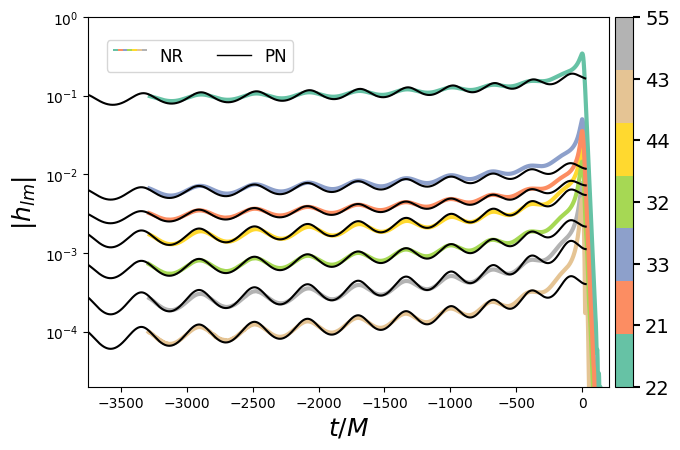

In [22]:
M0=40
M_SI=M0 * MSUN_SI
D_SI=(10**(6)) * PC_SI * 1
plt.figure(figsize=(8,4.8))
N = 7
cmap = plt.get_cmap('Set2', N)
sm = plt.cm.ScalarMappable(cmap=cmap)#, norm=norm)

cbar = plt.colorbar(sm, ticks=np.linspace(0, 1, N),pad=0.01)
#cbar.set_label(label='mode',size=20)
cbar.set_ticklabels(["22","21","33","32","44","43","55"])
cbar.ax.tick_params(labelsize=14,width=1.5, length=5)
cbar.ax.tick_params(which="minor",width=1, length=0)




import numpy as np
a55=np.loadtxt('PN55.txt')[:,0]
b55=np.loadtxt('PN55.txt')[:,1]
c55=np.loadtxt('NR55.txt')[:,0]
d55=np.loadtxt('NR55.txt')[:,1]
a43=np.loadtxt('PN43.txt')[:,0]
b43=np.loadtxt('PN43.txt')[:,1]
c43=np.loadtxt('NR43.txt')[:,0]
d43=np.loadtxt('NR43.txt')[:,1]
a44=np.loadtxt('PN44.txt')[:,0]
b44=np.loadtxt('PN44.txt')[:,1]
c44=np.loadtxt('NR44.txt')[:,0]
d44=np.loadtxt('NR44.txt')[:,1]
a32=np.loadtxt('PN32.txt')[:,0]
b32=np.loadtxt('PN32.txt')[:,1]
c32=np.loadtxt('NR32.txt')[:,0]
d32=np.loadtxt('NR32.txt')[:,1]
a33=np.loadtxt('PN33.txt')[:,0]
b33=np.loadtxt('PN33.txt')[:,1]
c33=np.loadtxt('NR33.txt')[:,0]
d33=np.loadtxt('NR33.txt')[:,1]
a21=np.loadtxt('PN21.txt')[:,0]
b21=np.loadtxt('PN21.txt')[:,1]
c21=np.loadtxt('NR21.txt')[:,0]
d21=np.loadtxt('NR21.txt')[:,1]
a22=np.loadtxt('PN22.txt')[:,0]
b22=np.loadtxt('PN22.txt')[:,1]
c22=np.loadtxt('NR22.txt')[:,0]
d22=np.loadtxt('NR22.txt')[:,1]
import matplotlib.pyplot as plt


#Time22=(time22-time22[np.argmax(abs(hp22+1j*hc22))]+time22[np.argmax(d22)])


ind=np.where(d55==max(d55))[0][0]
plt.plot(c55-c55[np.where(d55==max(d55))[0][0]],d55,linewidth=3.0,c=cmap(6))
plt.plot(c44-c44[np.where(d44==max(d44))[0][0]],d44,c=cmap(4),linewidth=3.0)
plt.plot(c43-c43[np.where(d43==max(d43))[0][0]],d43,c=cmap(5),linewidth=3.0)
plt.plot(c33-c33[np.where(d33==max(d33))[0][0]],d33,c=cmap(2),linewidth=3.0)
plt.plot(c32-c32[np.where(d32==max(d32))[0][0]],d32,c=cmap(3),linewidth=3.0)
plt.plot(c22-c22[np.where(d22==max(d22))[0][0]],d22,c=cmap(0),linewidth=3.0)
plt.plot(c21-c21[np.where(d21==max(d21))[0][0]],d21,c=cmap(1),linewidth=3.0)


plt.plot(time22/(40*MTSUN_SI)-32,abs(hp22+1j*hc22)/(G_SI*M_SI/D_SI/C_SI/C_SI),'k-')
plt.plot(time21/(40*MTSUN_SI)-32,abs(hp21+1j*hc21)/(G_SI*M_SI/D_SI/C_SI/C_SI),'k-')
plt.plot(time32/(40*MTSUN_SI)-32,abs(hp32+1j*hc32)/(G_SI*M_SI/D_SI/C_SI/C_SI),'k-')
plt.plot(time43/(40*MTSUN_SI)-32,abs(hp43+1j*hc43)/(G_SI*M_SI/D_SI/C_SI/C_SI),'k-')
plt.plot(time33/(40*MTSUN_SI)-32,abs(hp33+1j*hc33)/(G_SI*M_SI/D_SI/C_SI/C_SI),'k-')
plt.plot(time4/(40*MTSUN_SI)-32,abs(hp4+1j*hc4)/(G_SI*M_SI/D_SI/C_SI/C_SI),'k-')
plt.plot(time55/(40*MTSUN_SI)-32,abs(hp55+1j*hc55)/(G_SI*M_SI/D_SI/C_SI/C_SI),'k-')

#plt.axvline(x=0)




plt.ylim(ymax=1e0)
#plt.ylim(ymin=3e-6)
plt.ylim(ymin=2e-5)
plt.xlim(xmin=-3750)
plt.xlim(xmax=200)
plt.ylabel(r'$|h_{lm}|$',size=18)
plt.xlabel(r'$t/M$',size=18)
plt.yscale('log')


plt.minorticks_off()
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerBase
class HandlerColormap(HandlerBase):
    def __init__(self, cmap, num_stripes=8, **kw):
        HandlerBase.__init__(self, **kw)
        self.cmap = cmap
        self.num_stripes = num_stripes
    def create_artists(self, legend, orig_handle, 
                       xdescent, ydescent, width, height, fontsize, trans):
        stripes = []
        for i in range(self.num_stripes):
            s = Rectangle([xdescent + i * width / self.num_stripes, ydescent+7], 
                          width / self.num_stripes, 
                          height/4.5, 
                          fc=self.cmap((2 * i + 1) / (2 * self.num_stripes)), 
                          transform=trans)
            stripes.append(s)
        return stripes

x_array = np.linspace(10000, 10001, 1)
y_array = x_array
param_max = x_array.size
cmaps = [plt.get_cmap('Set2', 7)]#[plt.cm.Set2]  # set of colormaps 
                                        # (as many as there are groups of lines)

for param, (x, y) in enumerate(zip(x_array, y_array)):  
    x_line1 = np.linspace(x, 1.5 * x, 10)
    y_line1 = np.linspace(y**2, y**2 - x, 10)
    x_line2 = np.linspace(x, 1.5 * x, 10)
    y_line2 = np.linspace(y**2, y**2 - x, 10)

    # plot lines with color depending on param using different colormaps:
    plt.plot(x_line1, y_line1, c=cmaps[0](param / param_max))
    plt.plot(x_line2, y_line2)


lgd = Line2D([0], [0], color='black', lw=1)   
    
cmap_labels = ["NR","PN"]
cmap_handles = [Rectangle((0, 0), 1, 1)]
cmap_handles.append(lgd)
handler_map = dict(zip(cmap_handles, 
                       [HandlerColormap(cm, num_stripes=7) for cm in cmaps]))
plt.legend(handles=cmap_handles, 
           labels=cmap_labels, 
           handler_map=handler_map,bbox_to_anchor=(0.02,0.96),prop={'size': 12}, ncol = 2, loc=2)




#plt.savefig('Update_PN-NRCOMP.png',dpi=600)
plt.show()

54.373611150002795


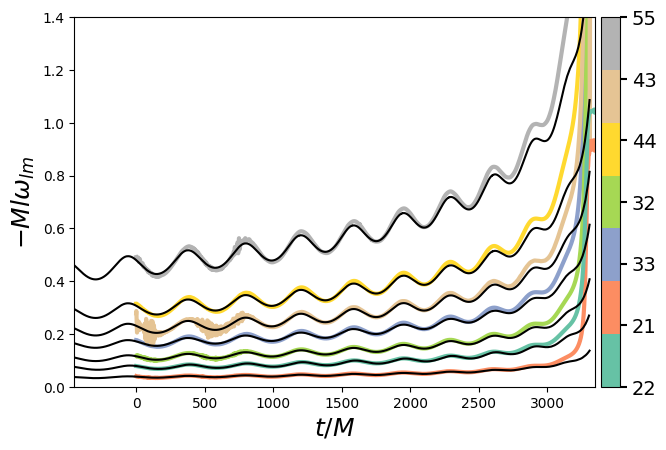

In [23]:
plt.figure(figsize=(8,4.8))
N = 7
cmap = plt.get_cmap('Set2', N)
sm = plt.cm.ScalarMappable(cmap=cmap)#, norm=norm)

cbar = plt.colorbar(sm, ticks=np.linspace(0, 1, N),pad=0.01)
#cbar.set_label(label='mode',size=20)
cbar.set_ticklabels(["22","21","33","32","44","43","55"])
cbar.ax.tick_params(labelsize=14,width=1.5, length=5)
cbar.ax.tick_params(which="minor",width=1, length=0)




import numpy as np


c55=np.loadtxt('nr55.txt')[:,0]
d55=np.loadtxt('nr55.txt')[:,1]


c43=np.loadtxt('nr43.txt')[:,0]
d43=np.loadtxt('nr43.txt')[:,1]


c44=np.loadtxt('nr44.txt')[:,0]
d44=np.loadtxt('nr44.txt')[:,1]


c32=np.loadtxt('nr32.txt')[:,0]
d32=np.loadtxt('nr32.txt')[:,1]


c33=np.loadtxt('nr33.txt')[:,0]
d33=np.loadtxt('nr33.txt')[:,1]

c21=np.loadtxt('nr21.txt')[:,0]
d21=np.loadtxt('nr21.txt')[:,1]

c22=np.loadtxt('nr22.txt')[:,0]
d22=np.loadtxt('nr22.txt')[:,1]
import matplotlib.pyplot as plt




plt.plot(c55,d55,linewidth=3.0,c=cmap(6))
plt.plot(c44,d44,c=cmap(4),linewidth=3.0)
plt.plot(c33,d33,c=cmap(2),linewidth=3.0)
plt.plot(c32,d32,c=cmap(3),linewidth=3.0)
plt.plot(c43,d43,c=cmap(5),linewidth=3.0)
plt.plot(c21,d21,c=cmap(1),linewidth=3.0)
plt.plot(c22,d22,c=cmap(0),linewidth=3.0)

print((time22/(40*MTSUN_SI))[-1])
plt.plot(time22/(40*MTSUN_SI)+3250,2*omega22,'k')
plt.plot(time21/(40*MTSUN_SI)+3250,2*omega21,'k')
plt.plot(time33/(40*MTSUN_SI)+3250,3*omega33,'k')
plt.plot(time32/(40*MTSUN_SI)+3250,3*omega32,'k')
plt.plot(time43/(40*MTSUN_SI)+3250,4*omega43,'k')
plt.plot(time4/(40*MTSUN_SI)+3250,4*omega44,'k')
plt.plot(time55/(40*MTSUN_SI)+3250,5*omega55,'k')
#tPN55[:lst]-tPN55[np.argmax(PNamp55)]-60 + tNR55[np.argmax(NRamp55)]
#plt.axvline(x=2000)

plt.ylim(ymax=1.4)
plt.ylim(ymin=3e-6)
plt.ylim(ymin=0.0)
plt.xlim(xmin=-450)
plt.xlim(xmax=3350)
plt.ylabel(r'$-Ml\omega_{lm}$',size=18)
plt.xlabel(r'$t/M$',size=18)
#plt.yscale('log')
#plt.savefig("update_PN-NR freq.png",dpi=300)

plt.show()

In [24]:
def PNparams(M,q,d,f_low,e0,delta_t):
    M2=M/(1+q)
    M1=M2*q
    hpVec_PN, hcVec_PN = get_td_waveform(approximant='EccentricTD', mass1=M1, mass2=M2, 
                             delta_t=delta_t, 
                             f_lower=f_low, 
                             eccentricity=e0,
                             distance=d)
    
    modetopolfac=4*(5/(64*np.pi))**(1/2)  #conversion factor between mode amplitude and strain amplitude
                                          # check 0704.3764 equation 7 for details
    M_SI = M * MSUN_SI
    D_SI = 10**6 * PC_SI * d
    phase_EccTD = waveform.utils.phase_from_polarizations(hpVec_PN/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)), hcVec_PN/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)))
    tVec_PN=hpVec_PN.sample_times/(M*MTSUN_SI)
    
    return phase_EccTD, tVec_PN

# $MISMATCH$

In [25]:
def old_INSP_Eber22(M0,q,e0,l0,flow,inc,d0,delta_t):
    eta=neu=nu=q/(1+q)**2
    G=c=M=d=1
    M2=M/(1+q)
    M1=M2*q
    Delta=math.sqrt(1-(4*neu))
    eta=nu=neu
    gamma=EulerGamma=0.577215664901
    mode2polfac=(5/(64*np.pi))**(1/2)
    
    conv=M*MTSUN_SI
    M_SI=M * MSUN_SI
    D_SI=(10**(6)) * PC_SI * d
    
    xlow = ((M0*MTSUN_SI*math.pi*flow)**(2/3))
    print(xlow)
    f_low = (xlow**(3/2)/(M*MTSUN_SI*math.pi))
    
    %run GW_functions.ipynb
    
    x=xlow
    v=math.sqrt(x)
    
    xie=v**3
    
    if delta_t>=1/2**14:
        del_t = 1/2**14
    elif delta_t<1/2**14 and delta_t>=1/2**16:
        del_t = 1/2**16
    elif delta_t<1/2**16 and delta_t>=1/2**18:
        del_t = 1/2**18
    else:
        del_t = 1/2**20
        
    phase_EccTD, tVec_PN = PNparams(M,q,d,f_low,e0,del_t)
    print(phase_EccTD[0])
    tC_NR = 0
    
    x0=xlow
    xi0=x0**(3/2)
    v0=xi0**(1/3)
   
    theta=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN)**(-1/8)
    theta0=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN[0])**(-1/8)
    fVec=x_from_t(theta, theta0, e0, M, eta)
    
    plotIdx2=np.nonzero(fVec>=0)
    fVec=fVec[plotIdx2]
    xiVec=(np.pi*M*fVec)
    xVec=xiVec**(2/3)
    vVec=xiVec**(1/3)
    xband=np.where(xVec<=1/6)
    xVec = xVec[xband]
    maxPNidx = len(xVec)
    tVec_PN=tVec_PN[:maxPNidx]
    
    
    lp=2
    mp=2
    
    j=0
    h22=[]
    h2_2=[]
    for i in xVec:    #tqdm(xVec) for status bar
        v=math.sqrt(i)
        v0=math.sqrt(x0)
        xie=v**3
        xi0=v0**3
        l=mean_anomaly(xie, xi0, l0, eta, e0)
        e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
        psi=phase_EccTD[j]
        j=j+1
        xi=l   #use xi for amplitude (xie is being used for v**3)
        x=i
        h=amplitude_22(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
        
        hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
        hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        
        h22.append(hlm)
        h2_2.append(hl_m)
        
    conv_t = M0*MTSUN_SI
    conv_h = G_SI*M0*MSUN_SI/(10**6 * PC_SI * d0)/C_SI/C_SI
    
    #sph22, sph2_2 = sph_harmonics(inc,lp)
    
    h = np.multiply(h22,1) #+np.multiply(h2_2,sph2_2)
    hp=(np.real(h)) 
    hc=(np.imag(h)) 
    time = tVec_PN #- tVec_PN[-1]

    #mode2polfac=(5/(64*np.pi))**(1/2)  
    
    hp = np.array(hp)
    hc = np.array(hc)
    time = tVec_PN
    
    hp_intrp = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
    hc_intrp = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
    t_intrp = np.arange(time[0], time[-1], delta_t)
    hp_intrp = hp_intrp(t_intrp)
    hc_intrp = hc_intrp(t_intrp)
    
    return np.array(hp_intrp), np.array(hc_intrp), np.array(t_intrp)

0.05351303645094325
0.0


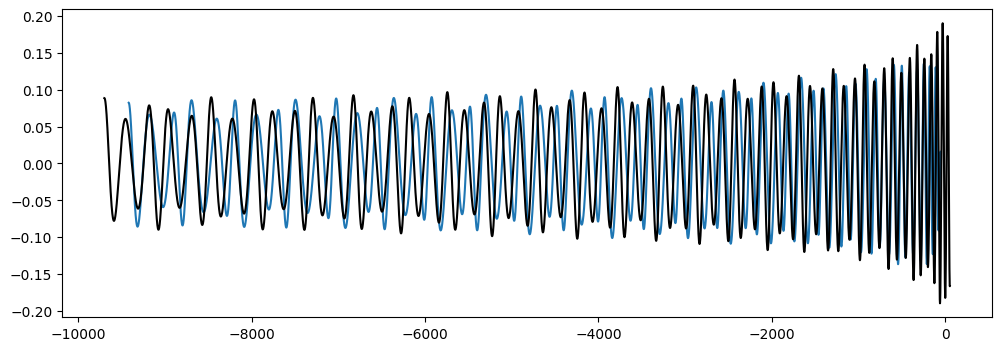

In [26]:
Hp,Hc,T = old_INSP_Eber22(40,2,0.12,-0.181,20,0,1,1./4096)
plt.figure(figsize=(12,4))
plt.plot(T,Hp)
Time22 = time22/(M0*MTSUN_SI)
Hp22 = hp22/(G_SI*M_SI/D_SI/C_SI/C_SI)
plt.plot(Time22,Hp22,'k')
#plt.xlim(-1.7,0.2)

In [28]:
f_low = (0.045**(3/2)/(30*MTSUN_SI*math.pi))
print(f_low)

20.563550931756406


# New Comparison EccentricTD

In [69]:
q=2 #mass ratio
M=30 #Total mass
nu=q/(1+q)**2
M1=q*M/(1+q)
M2=M/(1+q)
M_SI=M*MSUN_SI
D_SI=(10**6)*PC_SI
delta_t=1./4096
fmin=13.3 #21
e0 = 0.169 #0.061 #0.16909765517977837
modetopolfac=4*(5/(64*np.pi))**(1/2)
hp,hc=get_td_waveform(approximant='EccentricTD',mass1=M1,mass2=M2,delta_t=delta_t,f_lower=fmin,eccentricity=e0) 
Amp22 = waveform.utils.amplitude_from_polarizations(hp/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)), hc/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)))
phase_EccTD = waveform.utils.phase_from_polarizations(hp/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)), hc/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)))
tvec=hp.sample_times/(M*MTSUN_SI) 

omegaEcc22 = (M*MTSUN_SI/delta_t)*(np.gradient(phase_EccTD))
omegaEcc21 = (M*MTSUN_SI/delta_t)*(np.gradient(phase_EccTD*(1./2)))
omegaEcc33 = (M*MTSUN_SI/delta_t)*(np.gradient(phase_EccTD*(3./2)))
omegaEcc44 = (M*MTSUN_SI/delta_t)*(np.gradient(phase_EccTD*(4./2)))
omegaEcc43 = (M*MTSUN_SI/delta_t)*(np.gradient(phase_EccTD*(3./2)))
omegaEcc32 = (M*MTSUN_SI/delta_t)*(np.gradient(phase_EccTD*(2./2)))
omegaEcc55 = (M*MTSUN_SI/delta_t)*(np.gradient(phase_EccTD*(5./2)))

In [70]:
import numpy as np
a55=np.loadtxt('PN55.txt')[:,0]
b55=np.loadtxt('PN55.txt')[:,1]
c55=np.loadtxt('NR55.txt')[:,0]
d55=np.loadtxt('NR55.txt')[:,1]
a43=np.loadtxt('PN43.txt')[:,0]
b43=np.loadtxt('PN43.txt')[:,1]
c43=np.loadtxt('NR43.txt')[:,0]
d43=np.loadtxt('NR43.txt')[:,1]
a44=np.loadtxt('PN44.txt')[:,0]
b44=np.loadtxt('PN44.txt')[:,1]
c44=np.loadtxt('NR44.txt')[:,0]
d44=np.loadtxt('NR44.txt')[:,1]
a32=np.loadtxt('PN32.txt')[:,0]
b32=np.loadtxt('PN32.txt')[:,1]
c32=np.loadtxt('NR32.txt')[:,0]
d32=np.loadtxt('NR32.txt')[:,1]
a33=np.loadtxt('PN33.txt')[:,0]
b33=np.loadtxt('PN33.txt')[:,1]
c33=np.loadtxt('NR33.txt')[:,0]
d33=np.loadtxt('NR33.txt')[:,1]
a21=np.loadtxt('PN21.txt')[:,0]
b21=np.loadtxt('PN21.txt')[:,1]
c21=np.loadtxt('NR21.txt')[:,0]
d21=np.loadtxt('NR21.txt')[:,1]
a22=np.loadtxt('PN22.txt')[:,0]
b22=np.loadtxt('PN22.txt')[:,1]
c22=np.loadtxt('NR22.txt')[:,0]
d22=np.loadtxt('NR22.txt')[:,1]
import matplotlib.pyplot as plt

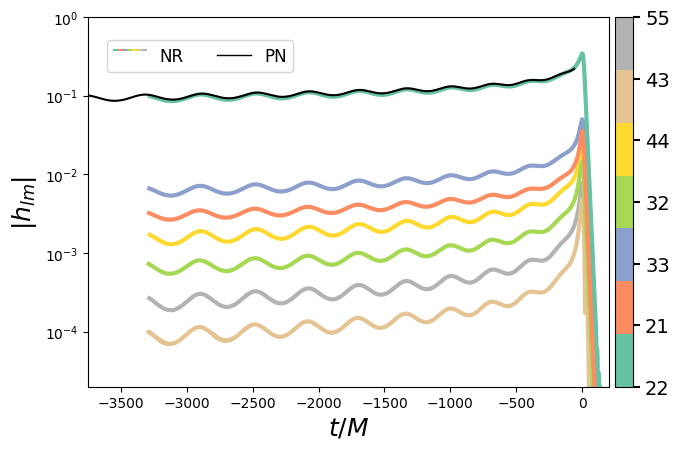

In [74]:
M0=30
M_SI=M0 * MSUN_SI
D_SI=(10**(6)) * PC_SI * 1
plt.figure(figsize=(8,4.8))
N = 7
cmap = plt.get_cmap('Set2', N)
sm = plt.cm.ScalarMappable(cmap=cmap)#, norm=norm)

cbar = plt.colorbar(sm, ticks=np.linspace(0, 1, N),pad=0.01)
cbar.set_ticklabels(["22","21","33","32","44","43","55"])
cbar.ax.tick_params(labelsize=14,width=1.5, length=5)
cbar.ax.tick_params(which="minor",width=1, length=0)


# Do calculate match 
#for i in range(0,200):
    




#NR data
ind=np.where(d55==max(d55))[0][0]
plt.plot(c55-c55[np.where(d55==max(d55))[0][0]],d55,linewidth=3.0,c=cmap(6))
plt.plot(c44-c44[np.where(d44==max(d44))[0][0]],d44,c=cmap(4),linewidth=3.0)
plt.plot(c43-c43[np.where(d43==max(d43))[0][0]],d43,c=cmap(5),linewidth=3.0)
plt.plot(c33-c33[np.where(d33==max(d33))[0][0]],d33,c=cmap(2),linewidth=3.0)
plt.plot(c32-c32[np.where(d32==max(d32))[0][0]],d32,c=cmap(3),linewidth=3.0)
plt.plot(c22-c22[np.where(d22==max(d22))[0][0]],d22,c=cmap(0),linewidth=3.0)
plt.plot(c21-c21[np.where(d21==max(d21))[0][0]],d21,c=cmap(1),linewidth=3.0)

#PN data
plt.semilogy(tvec-60,Amp22,'k-',label='EccTD') #tvec-120


plt.ylim(ymax=1e0)
#plt.ylim(ymin=3e-6)
plt.ylim(ymin=2e-5)
plt.xlim(xmin=-3750)
plt.xlim(xmax=200)
plt.ylabel(r'$|h_{lm}|$',size=18)
plt.xlabel(r'$t/M$',size=18)
plt.yscale('log')


plt.minorticks_off()
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerBase
class HandlerColormap(HandlerBase):
    def __init__(self, cmap, num_stripes=8, **kw):
        HandlerBase.__init__(self, **kw)
        self.cmap = cmap
        self.num_stripes = num_stripes
    def create_artists(self, legend, orig_handle, 
                       xdescent, ydescent, width, height, fontsize, trans):
        stripes = []
        for i in range(self.num_stripes):
            s = Rectangle([xdescent + i * width / self.num_stripes, ydescent+7], 
                          width / self.num_stripes, 
                          height/4.5, 
                          fc=self.cmap((2 * i + 1) / (2 * self.num_stripes)), 
                          transform=trans)
            stripes.append(s)
        return stripes

x_array = np.linspace(10000, 10001, 1)
y_array = x_array
param_max = x_array.size
cmaps = [plt.get_cmap('Set2', 7)]#[plt.cm.Set2]  # set of colormaps 
                                        # (as many as there are groups of lines)

for param, (x, y) in enumerate(zip(x_array, y_array)):  
    x_line1 = np.linspace(x, 1.5 * x, 10)
    y_line1 = np.linspace(y**2, y**2 - x, 10)
    x_line2 = np.linspace(x, 1.5 * x, 10)
    y_line2 = np.linspace(y**2, y**2 - x, 10)

    # plot lines with color depending on param using different colormaps:
    plt.plot(x_line1, y_line1, c=cmaps[0](param / param_max))
    plt.plot(x_line2, y_line2)


lgd = Line2D([0], [0], color='black', lw=1)   
    
cmap_labels = ["NR","PN"]
cmap_handles = [Rectangle((0, 0), 1, 1)]
cmap_handles.append(lgd)
handler_map = dict(zip(cmap_handles, 
                       [HandlerColormap(cm, num_stripes=7) for cm in cmaps]))
plt.legend(handles=cmap_handles, 
           labels=cmap_labels, 
           handler_map=handler_map,bbox_to_anchor=(0.02,0.96),prop={'size': 12}, ncol = 2, loc=2)




#plt.savefig('Update_PN-NRCOMP.png',dpi=600)
plt.show()

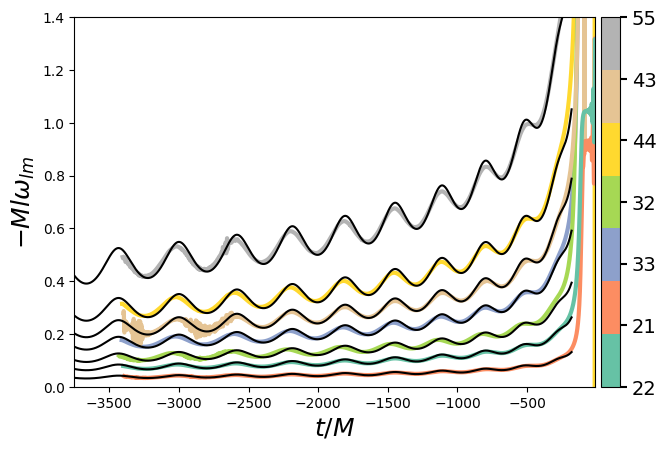

In [66]:
plt.figure(figsize=(8,4.8))
N = 7
cmap = plt.get_cmap('Set2', N)
sm = plt.cm.ScalarMappable(cmap=cmap)#, norm=norm)

cbar = plt.colorbar(sm, ticks=np.linspace(0, 1, N),pad=0.01)
#cbar.set_label(label='mode',size=20)
cbar.set_ticklabels(["22","21","33","32","44","43","55"])
cbar.ax.tick_params(labelsize=14,width=1.5, length=5)
cbar.ax.tick_params(which="minor",width=1, length=0)




import numpy as np


c55=np.loadtxt('nr55.txt')[:,0]
d55=np.loadtxt('nr55.txt')[:,1]


c43=np.loadtxt('nr43.txt')[:,0]
d43=np.loadtxt('nr43.txt')[:,1]


c44=np.loadtxt('nr44.txt')[:,0]
d44=np.loadtxt('nr44.txt')[:,1]


c32=np.loadtxt('nr32.txt')[:,0]
d32=np.loadtxt('nr32.txt')[:,1]


c33=np.loadtxt('nr33.txt')[:,0]
d33=np.loadtxt('nr33.txt')[:,1]

c21=np.loadtxt('nr21.txt')[:,0]
d21=np.loadtxt('nr21.txt')[:,1]

c22=np.loadtxt('nr22.txt')[:,0]
d22=np.loadtxt('nr22.txt')[:,1]
import matplotlib.pyplot as plt




plt.plot(c55-c55[np.argmax(d55)],d55,linewidth=3.0,c=cmap(6))
plt.plot(c44-c44[np.argmax(d44)],d44,c=cmap(4),linewidth=3.0)
plt.plot(c33-c33[np.argmax(d33)],d33,c=cmap(2),linewidth=3.0)
plt.plot(c32-c32[np.argmax(d32)],d32,c=cmap(3),linewidth=3.0)
plt.plot(c43-c43[np.argmax(d43)],d43,c=cmap(5),linewidth=3.0)
plt.plot(c21-c21[np.argmax(d21)],d21,c=cmap(1),linewidth=3.0)
plt.plot(c22-c22[np.argmax(d22)],d22,c=cmap(0),linewidth=3.0)

plt.plot(tvec-tvec[np.argmax(Amp22)]-180,2*omegaEcc22,'k-')
plt.plot(tvec-tvec[np.argmax(Amp22)]-180,2*omegaEcc21,'k-') #120
plt.plot(tvec-tvec[np.argmax(Amp22)]-180,3*omegaEcc33,'k-')
plt.plot(tvec-tvec[np.argmax(Amp22)]-180,4*omegaEcc44,'k-')
plt.plot(tvec-tvec[np.argmax(Amp22)]-180,4*omegaEcc43,'k-')
plt.plot(tvec-tvec[np.argmax(Amp22)]-180,3*omegaEcc32,'k-')
plt.plot(tvec-tvec[np.argmax(Amp22)]-180,5*omegaEcc55,'k-')


plt.ylim(ymax=1.4)
plt.ylim(ymin=3e-6)
plt.ylim(ymin=0.0)
plt.xlim(xmin=-3750)
plt.xlim(xmax=-10)
plt.ylabel(r'$-Ml\omega_{lm}$',size=18)
plt.xlabel(r'$t/M$',size=18)
#plt.yscale('log')
#plt.savefig("update_PN-NR freq.png",dpi=300)

plt.show()